In [1]:
import os.path
import datetime as dt
from os import listdir,mkdir
from os.path import isfile, isdir,join
import cv2
import pandas as pd
from  matplotlib import pyplot as plt
%matplotlib inline
import time
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import keras
from keras import applications
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

In [2]:
datapath='../davinci/2021_04_15_11_53_57/ImgThreshold/dataset_ts.csv'
csv=pd.read_csv(datapath)
csv.head()
data_W=csv['w']
data_M=csv['m']
data_I=csv['i']

In [3]:
IMAGE_WIDTH=50
IMAGE_HEIGHT=50

In [4]:
img_array=[cv2.resize(cv2.imread(i), (IMAGE_WIDTH, IMAGE_HEIGHT)) for i in data_I]

In [73]:
X=np.asarray(img_array)
X=X.astype('float32')
X /= 255 #normalize
print(len(X_img))

866


In [74]:
w=np.array(data_W).reshape(-1, 1)
min_max_scaler = MinMaxScaler()
y=min_max_scaler.fit_transform(w)
print(len(y))

866


In [75]:
#切割 訓練集/測試集 
X_train, X_other, y_train, y_other = train_test_split(X, y,test_size = 0.3,random_state = 0)
X_test, X_valid, y_test, y_valid = train_test_split(X_other, y_other,test_size = 0.3,random_state = 0)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_valid.shape)
print(y_valid.shape)

(606, 50, 50, 3)
(606, 1)
(182, 50, 50, 3)
(182, 1)
(78, 50, 50, 3)
(78, 1)


In [76]:
# 使用VGG16模型
base_model = applications.VGG16(include_top=False, weights='imagenet', input_shape=(50, 50, 3))  # 第一層指出圖片尺寸
# # path to the model weights files.
# top_model_weights_path = 'bottleneck_fc_model.h5'
print(X_train.shape[1:])
model = Sequential()
print(base_model.output)
model.add(Flatten(input_shape=base_model.output_shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('linear'))

# add the model on top of the convolutional base
model = Model(inputs=base_model.input, outputs=model(base_model.output))  # 合併VGG16模型

# 保持VGG16的前15層不訓練  
for layer in model.layers[:15]:
    layer.trainable = False

# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)
#keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-6)

# Let's train the model using RMSprop
model.compile(loss='mse', optimizer=opt, )

(50, 50, 3)
KerasTensor(type_spec=TensorSpec(shape=(None, 1, 1, 512), dtype=tf.float32, name=None), name='block5_pool/MaxPool:0', description="created by layer 'block5_pool'")


In [77]:
batch_size = 32
epochs = 5
data_augmentation = True  # 图像增强
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models_transfer_learning')
model_name = 'davinci_transfer_learning_trained_model.h5'

In [78]:
if data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(X_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(X_train)
    print(X_train.shape[0]//batch_size)  # 取整
    print(X_train.shape[0]/batch_size)  # 保留小数
    # Fit the model on the batches generated by datagen.flow().
    history = model.fit_generator(datagen.flow(X_train, y_train,  # 按batch_size大小从x,y生成增强数据
                                     batch_size=batch_size),  
                        # flow_from_directory()从路径生成增强数据,和flow方法相比最大的优点在于不用
                        # 一次将所有的数据读入内存当中,这样减小内存压，这样不会发生OOM
                        epochs=epochs,
                        steps_per_epoch=X_train.shape[0]//batch_size,
                        validation_data=(X_test, y_test),
                        workers=10  # 在使用基于进程的线程时，最多需要启动的进程数量。
                       )

Not using data augmentation.
Epoch 1/5
19/19 [==============================] - 32s 2s/step - loss: 0.7267 - val_loss: 0.0275
Epoch 2/5
19/19 [==============================] - 30s 2s/step - loss: 0.0826 - val_loss: 0.0253
Epoch 3/5
19/19 [==============================] - 29s 2s/step - loss: 0.0481 - val_loss: 0.0030
Epoch 4/5
19/19 [==============================] - 30s 2s/step - loss: 0.0489 - val_loss: 0.0301
Epoch 5/5
19/19 [==============================] - 30s 2s/step - loss: 0.0425 - val_loss: 0.0053


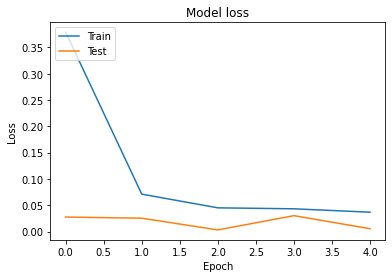

In [79]:
import matplotlib.pyplot as plt
# 绘制训练 & 验证的损失值
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [154]:
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at d:\達文西手臂\VS_Code\OpenCVforTesting\saved_models_transfer_learning\davinci_transfer_learning_trained_model.h5 


使用 "davinci\2021_04_15_11_47_46" 資料預測重量 , 取重量log 介於 1g< weight <2000g 的資料

In [81]:
y_pred = model.predict(X_valid)
#y_pred_verse=min_max_scaler.inverse_transform(y_pred)
#outpred=pd.DataFrame({'true':y_valid.flatten(),'pred':y_pred_verse.flatten()})
#outpred


In [82]:
#R2 Score
from sklearn.metrics import r2_score
r2_score(y_valid,y_pred)

0.9245073966038413

In [83]:
# RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(y_valid, y_pred))
print(rms)

0.0732472981494023
